## Vision Transformer 

In [1]:
!pip install ml_collections

Looking in indexes: http://ftp.daumkakao.com/pypi/simple


### Imporing Libraries

In [68]:
import os, copy, logging, math, random, time, typing, io, cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar10, cifar100

# import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import ndimage

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
import torchvision
from torchvision import transforms, datasets
import torch.distributed as dist
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler
from torch.optim.lr_scheduler import LambdaLR
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import utils
import torch.nn.functional as F

from matplotlib.colors import LogNorm 

from urllib.request import urlretrieve
from PIL import Image
from os.path import join as pjoin

from tqdm import tqdm
from datetime import timedelta
from __future__ import absolute_import, division, print_function 
import ml_collections

### Download Pre-trained model

In [3]:
!wget https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz

--2021-11-05 17:55:46--  https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.174.112, 216.58.220.144, 216.58.220.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.174.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412815506 (394M) [application/octet-stream]
Saving to: ‘ViT-B_16.npz.1’

ViT-B_16.npz.1      100%[===================>] 393.69M  22.0MB/s    in 19s     

2021-11-05 17:56:07 (20.5 MB/s) - ‘ViT-B_16.npz.1’ saved [412815506/412815506]



### Check GPU Access

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda:1")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla V100-SXM2-32GB


### Configurations 

In [69]:
def get_testing():
    '''
    Returns a minimal configuration for testing
    '''
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 1
    config.transformer.num_heads = 1
    config.transformer.num_layers = 1
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

def get_b16_config():
    '''
    Returns the ViT-B/16 configuration
    '''
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

def get_b32_config():
    '''
    Returns the ViT-B/32 configuration
    '''
    config = get_b16_config()
    config.patches.size = (32, 32)
    return config

def get_l16_config():
    '''
    Returns the ViT-L/16 configuration
    '''
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 1024
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 4096
    config.transformer.num_heads = 16
    config.transformer.num_layers = 24
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

def get_l32_config():
    '''
    Returns the ViT-L/32 configuration
    '''
    config = get_l16_config()
    config.patches.size = (32, 32)
    return config

def get_h14_config():
    '''
    Returns the ViT-L/16 configuration
    '''
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (14, 14)})
    config.hidden_size = 1280
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 5120
    config.transformer.num_heads = 16
    config.transformer.num_layers = 32
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    config.classifier = 'token'
    config.representation_size = None
    return config

### Model Architecture

In [70]:
logger = logging.getLogger(__name__)

ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights):
    """Possibly convert HWIO to OIHW."""
    if weights.ndim == 4:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

def swish(x):
    return x * torch.sigmoid(x)

ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Embeddings(nn.Module):
    '''
    Construct the embeddings from patch, position embeddings
    '''
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        img_size = _pair(img_size)
        patch_size = _pair(config.patches["size"])
        n_patches = (img_size[0]//patch_size[0]) * (img_size[1]//patch_size[1])

        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, config.hidden_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel")]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias")]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias")]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias")]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias")]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel")]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel")]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias")]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias")]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale")]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias")]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale")]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias")]))


class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights


class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights


class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier

        self.transformer = Transformer(config, img_size, vis)
        self.head = Linear(config.hidden_size, num_classes)

    def forward(self, x, labels=None):
        x, attn_weights = self.transformer(x)
        logits = self.head(x[:, 0])

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
            return loss
        else:
            return logits, attn_weights

    def load_from(self, weights):
        with torch.no_grad():
            if self.zero_head:
                nn.init.zeros_(self.head.weight)
                nn.init.zeros_(self.head.bias)
            else:
                self.head.weight.copy_(np2th(weights["head/kernel"]).t())
                self.head.bias.copy_(np2th(weights["head/bias"]).t())

            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"]))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))
            self.transformer.embeddings.cls_token.copy_(np2th(weights["cls"]))
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])
            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)

                if self.classifier == "token":
                    posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
                    ntok_new -= 1
                else:
                    posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)

                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = np.concatenate([posemb_tok, posemb_grid], axis=1)
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)


CONFIGS = {
    'ViT-B_16': get_b16_config(),
    'ViT-B_32': get_b32_config(),
    'ViT-L_16': get_l16_config(),
    'ViT-L_32': get_l32_config(),
    'ViT-H_14': get_h14_config(),
    'testing': get_testing(),
}

### Load Model

In [71]:
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, img_size=224, num_classes=21843, zero_head=False, vis=True)
model.load_from(np.load("ViT-B_16.npz"))
model.to(device)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0): Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=True)
     

### Utilities

In [72]:
def get_world_size():
    if not dist.is_available():
        return 1
    if not dist.is_initialized():
        return 1
    return dist.get_world_size()

### Dataloader

In [73]:
def get_loader(local_rank, img_size, dataset, train_batch_size, eval_batch_size):
    if local_rank not in [-1, 0]:
        torch.distributed.barrier()

    transform_train = transforms.Compose([
        transforms.RandomResizedCrop((img_size, img_size), scale=(0.05, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    if dataset == "cifar10":
        trainset = datasets.CIFAR10(root="./data",
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        testset = datasets.CIFAR10(root="./data",
                                   train=False,
                                   download=True,
                                   transform=transform_test) if local_rank in [-1, 0] else None

    else:
        trainset = datasets.CIFAR100(root="./data",
                                     train=True,
                                     download=True,
                                     transform=transform_train)
        testset = datasets.CIFAR100(root="./data",
                                    train=False,
                                    download=True,
                                    transform=transform_test) if local_rank in [-1, 0] else None
    if local_rank == 0:
        torch.distributed.barrier()

    train_sampler = RandomSampler(trainset) if local_rank == -1 else DistributedSampler(trainset)
    test_sampler = SequentialSampler(testset)
    train_loader = DataLoader(trainset,
                              sampler=train_sampler,
                              batch_size=train_batch_size,
                              num_workers=4,
                              pin_memory=True)
    test_loader = DataLoader(testset,
                             sampler=test_sampler,
                             batch_size=eval_batch_size,
                             num_workers=4,
                             pin_memory=True) if testset is not None else None

    return train_loader, test_loader

### Scheduler

In [74]:
class ConstantLRSchedule(LambdaLR):
    """ Constant learning rate schedule.
    """
    def __init__(self, optimizer, last_epoch=-1):
        super(ConstantLRSchedule, self).__init__(optimizer, lambda _: 1.0, last_epoch=last_epoch)


class WarmupConstantSchedule(LambdaLR):
    """ Linear warmup and then constant.
        Linearly increases learning rate schedule from 0 to 1 over `warmup_steps` training steps.
        Keeps learning rate schedule equal to 1. after warmup_steps.
    """
    def __init__(self, optimizer, warmup_steps, last_epoch=-1):
        self.warmup_steps = warmup_steps
        super(WarmupConstantSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        return 1.


class WarmupLinearSchedule(LambdaLR):
    """ Linear warmup and then linear decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Linearly decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps.
    """
    def __init__(self, optimizer, warmup_steps, t_total, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        super(WarmupLinearSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1, self.warmup_steps))
        return max(0.0, float(self.t_total - step) / float(max(1.0, self.t_total - self.warmup_steps)))


class WarmupCosineSchedule(LambdaLR):
    """ Linear warmup and then cosine decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps following a cosine curve.
        If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    def __init__(self, optimizer, warmup_steps, t_total, cycles=.5, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        self.cycles = cycles
        super(WarmupCosineSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        # progress after warmup
        progress = float(step - self.warmup_steps) / float(max(1, self.t_total - self.warmup_steps))
        return max(0.0, 0.5 * (1. + math.cos(math.pi * float(self.cycles) * 2.0 * progress)))

### Training 

In [75]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def simple_accuracy(preds, labels):
    return (preds == labels).mean()


def save_model(output_dir, name, model):
    model_to_save = model.module if hasattr(model, 'module') else model
    model_checkpoint = os.path.join(output_dir, "%s_checkpoint.bin" % name)
    torch.save(model_to_save.state_dict(), model_checkpoint)
    logger.info("Saved model checkpoint to [DIR: %s]", output_dir)


def setup(model_type, img_size, pretrained_dir, device, dataset):
    # Prepare model
    config = CONFIGS[model_type]

    num_classes = 10 if dataset == "cifar10" else 100

    model = VisionTransformer(config, img_size, zero_head=True, num_classes=num_classes)
    model.load_from(np.load(pretrained_dir))
    model.to(device)
    num_params = count_parameters(model)

    logger.info("{}".format(config))
    logger.info("Training parameters %s", model_type, img_size, pretrained_dir, device)
    logger.info("Total Parameter: \t%2.1fM" % num_params)
    return model_type, img_size, pretrained_dir, device, model


def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000


def set_seed(seed, n_gpu):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

In [76]:
def valid(eval_batch_size, local_rank, device, model, writer, test_loader, global_step):
    # Validation!
    eval_losses = AverageMeter()

    logger.info("***** Running Test *****")
    logger.info("  Num steps = %d", len(test_loader))
    logger.info("  Batch size = %d", eval_batch_size)

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Test... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits, attn_weights = model(x)

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Testing... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    logger.info("\n")
    logger.info("Test Results")
    logger.info("Global Steps: %d" % global_step)
    logger.info("Test Loss: %2.5f" % eval_losses.avg)
    logger.info("Test Accuracy: %2.5f" % accuracy)

    writer.add_scalar("test/accuracy", scalar_value=accuracy, global_step=global_step)
    return accuracy

In [77]:
def train(local_rank, output_dir, name, train_batch_size, eval_batch_size, seed, n_gpu, gradient_accumulation_steps, dataset, img_size, learning_rate, weight_decay, num_steps, decay_type, warmup_steps, fp16, fp16_opt_level, device, max_grad_norm, eval_every, model):
    """ Train the model """
    if local_rank in [-1, 0]:
        os.makedirs(output_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=os.path.join("logs", name))

    train_batch_size = train_batch_size // gradient_accumulation_steps

    # Prepare dataset
    train_loader, test_loader = get_loader(local_rank, img_size, dataset, train_batch_size, eval_batch_size)

    # Prepare optimizer and scheduler
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=0.9,
                                weight_decay=weight_decay)
    t_total = num_steps
    if decay_type == "cosine":
        scheduler = WarmupCosineSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total)
    else:
        scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_steps, t_total=t_total)

    if fp16:
        model, optimizer = amp.initialize(models=model,
                                          optimizers=optimizer,
                                          opt_level=fp16_opt_level)
        amp._amp_state.loss_scalers[0]._loss_scale = 2**20

    # Distributed training
    if local_rank != -1:
        model = DDP(model, message_size=250000000, gradient_predivide_factor=get_world_size())

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Total optimization steps = %d", num_steps)
    logger.info("  Instantaneous batch size per GPU = %d", train_batch_size)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                train_batch_size * gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", gradient_accumulation_steps)

    model.zero_grad()
    set_seed(seed, n_gpu)  # Added here for reproducibility (even between python 2 and 3)
    losses = AverageMeter()
    global_step, best_acc = 0, 0
    train_accs = []
    test_accs = []

    while True:
        model.train()
        epoch_iterator = tqdm(train_loader,
                              desc="Training (X / X Steps) (loss=X.X)",
                              bar_format="{l_bar}{r_bar}",
                              dynamic_ncols=True,
                              disable=local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            batch = tuple(t.to(device) for t in batch)
            x, y = batch
            loss = model(x, y)

            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps
            if fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                losses.update(loss.item()*gradient_accumulation_steps)
                if fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scheduler.step()
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1

                epoch_iterator.set_description(
                    "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, t_total, losses.val)
                )
                if local_rank in [-1, 0]:
                    writer.add_scalar("train/loss", scalar_value=losses.val, global_step=global_step)
                    writer.add_scalar("train/lr", scalar_value=scheduler.get_lr()[0], global_step=global_step)
                if global_step % eval_every == 0 and local_rank in [-1, 0]:
                    accuracy = valid(eval_batch_size, local_rank, device, model, writer, test_loader, global_step)
                    test_accs.append(accuracy)
                    if best_acc < accuracy:
                        save_model(output_dir, name, model)
                        best_acc = accuracy
                    model.train()

                if global_step % 5 == 0:
                    torch.save({
                        'epoch': global_step,
                        'model': model,
                        'optimizer': optimizer,
                        'scheduler': scheduler,
                        'test_acc': test_accs
                    }, './checkpoint.pt')

                if global_step % t_total == 0:
                    break
        losses.reset()
        if global_step % t_total == 0:
            break

    if local_rank in [-1, 0]:
        writer.close()
    logger.info("Best Accuracy: \t%f" % best_acc)
    logger.info("End Training!")

In [78]:
def main():
    # Required parameters
    name = "cifar100_500"                               # Name of this run. Used for monitoring
    dataset = "cifar100"                                # Which downstream task, choices=["cifar10", "cifar100"]
    model_type = "ViT-B_16"                             # Which variant to use
    pretrained_dir = "ViT-B_16.npz"                     # Where to search for pretrained ViT models
    output_dir = "output_cifar100"                      # The output directory where checkpoints will be written
    img_size = 224  #224                                 # Resolution size
    train_batch_size = 64                               # Total batch size for training
    eval_batch_size = 64                                # Total batch size for eval
    eval_every = 100                                    # Run prediction on validation set every so many steps (Will always run one evaluation at the end of training)
    learning_rate = 3e-2                                # The initial learning rate for SGD
    weight_decay = 0                                    # Weight deay if we apply some
    num_steps = 500                                     # Total number of training epochs to perform
    decay_type = "cosine"                               # How to decay the learning rate, choices=["cosine", "linear"]
    warmup_steps = 100                                  # Step of training to perform learning rate warmup for
    max_grad_norm = 1.0                                 # Max gradient norm
    local_rank = -1                                     # local_rank for distributed training on gpus
    seed = 42                                           # random seed for initialization
    gradient_accumulation_steps = 1                     # Number of updates steps to accumulate before performing a backward/update pass
    fp16 = 0                                            # (action = 'store_true') Whether to use 16-bit float precision instead of 32-bit
    fp16_opt_level = 'store_true'                       # For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']
    loss_scale = 0                                      # Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True (0 (default value): dynamic loss scaling, Positive power of 2: static loss scaling value)
    local_rank = -1                                     # local_rank for distributed training on gpus

    device="cpu"
    n_gpu = 0

    # Setup CUDA, GPU & distributed training
    if local_rank == -1:
        device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        n_gpu = torch.cuda.device_count()
    else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.cuda.set_device(local_rank)
        device = torch.device("cuda:1", local_rank)
        torch.distributed.init_process_group(backend='nccl',
                                             timeout=timedelta(minutes=60))
        n_gpu = 1

    # Setup logging
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO if local_rank in [-1, 0] else logging.WARN)
    logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s" %
                   (local_rank, device, n_gpu, bool(local_rank != -1), fp16))

    # Set seed
    set_seed(seed, n_gpu)

    # Model & Tokenizer Setup
    model_type, img_size, pretrained_dir, device, model = setup(model_type, img_size, pretrained_dir, device, dataset)

    # Training
    train(local_rank, output_dir, name, train_batch_size, eval_batch_size, seed, n_gpu, gradient_accumulation_steps, dataset, img_size, learning_rate, weight_decay, num_steps, decay_type, warmup_steps, fp16, fp16_opt_level, device, max_grad_norm, eval_every, model)

### Running the trainer


In [79]:
main()

11/05/2021 21:12:30 - WARNING - __main__ - Process rank: -1, device: cuda:1, n_gpu: 3, distributed training: False, 16-bits training: 0
11/05/2021 21:12:33 - INFO - __main__ - classifier: token
hidden_size: 768
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.8/logging/__init__.py", line 1081, in emit
    msg = self.format(record)
  File "/home/ubuntu/miniconda3/lib/python3.8/logging/__init__.py", line 925, in format
    return fmt.format(record)
  File "/home/ubuntu/miniconda3/lib/python3.8/logging/__init__.py", line 664, in format
    record.message = record.getMessage()
  File "/home/ubuntu/miniconda3/lib/python3.8/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
C

Files already downloaded and verified
Files already downloaded and verified


11/05/2021 21:12:35 - INFO - __main__ - ***** Running training *****
11/05/2021 21:12:35 - INFO - __main__ -   Total optimization steps = 500
11/05/2021 21:12:35 - INFO - __main__ -   Instantaneous batch size per GPU = 64
11/05/2021 21:12:35 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 64
11/05/2021 21:12:35 - INFO - __main__ -   Gradient Accumulation steps = 1
Training (100 / 500 Steps) (loss=3.61231):  13%|| 99/782 [01:54<10:07,  1.12it/s]11/05/2021 21:14:30 - INFO - __main__ - ***** Running Test *****
11/05/2021 21:14:30 - INFO - __main__ -   Num steps = 157
11/05/2021 21:14:30 - INFO - __main__ -   Batch size = 64

Testing... (loss=3.36171): 100%|| 157/157 [00:34<00:00,  4.57it/s]
11/05/2021 21:15:04 - INFO - __main__ - 

11/05/2021 21:15:04 - INFO - __main__ - Test Results
11/05/2021 21:15:04 - INFO - __main__ - Global Steps: 100
11/05/2021 21:15:04 - INFO - __main__ - Test Loss: 3.34167
11/05/2021 21:15:04 - INFO - __main__ - Test Accur

### Testing 

In [80]:
class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier

        self.transformer = Transformer(config, img_size, vis)
        self.head = Linear(config.hidden_size, num_classes)

    def forward(self, x, labels=None):
        x, attn_weights = self.transformer(x)
        logits = self.head(x[:, 0])

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
            return loss
        else:
            return logits #, attn_weights

    def load_from(self, weights):
        with torch.no_grad():
            if self.zero_head:
                nn.init.zeros_(self.head.weight)
                nn.init.zeros_(self.head.bias)
            else:
                self.head.weight.copy_(np2th(weights["head/kernel"]).t())
                self.head.bias.copy_(np2th(weights["head/bias"]).t())

            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"]))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))
            self.transformer.embeddings.cls_token.copy_(np2th(weights["cls"]))
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])
            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)

                if self.classifier == "token":
                    posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
                    ntok_new -= 1
                else:
                    posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)

                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = np.concatenate([posemb_tok, posemb_grid], axis=1)
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

In [115]:
model = VisionTransformer(config, img_size=224, zero_head=True, num_classes=100)
checkpoint = torch.load("output_cifar100/cifar100_500_checkpoint.bin") 

model.load_state_dict(checkpoint) 
model.to(device)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0): Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=True)
     

In [116]:
model.eval()

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0): Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=True)
     

In [117]:
from PIL import Image

image_dir = '0005.png'

input_image = Image.open(image_dir)

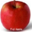

In [118]:
input_image

In [119]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

x = transform(input_image)

In [120]:
x.size()

torch.Size([3, 224, 224])

In [123]:
x = x.to(device)

In [124]:
logits = model(x.unsqueeze(0))

preds = torch.argmax(logits, dim=-1)
preds

tensor([0], device='cuda:1')

In [125]:
logits

tensor([[ 7.8992e+00,  4.6909e-01,  5.0083e-02, -7.1851e-01, -6.4249e-01,
         -3.7722e-01,  8.6283e-02,  2.3017e-01, -2.8317e-01,  4.6696e-01,
          9.9816e-01,  9.3340e-02, -4.5178e-01, -3.7654e-01, -8.7495e-02,
         -8.0172e-01,  6.3487e-01, -2.3182e-01, -2.1290e-01, -2.5988e-01,
         -8.8064e-02, -5.8691e-01,  2.7822e-01, -5.9778e-01,  3.9020e-01,
         -1.5187e-01,  4.4171e-01, -5.8582e-01,  7.5145e-01, -5.2795e-01,
         -1.9603e-01, -4.7016e-01, -1.4039e-01, -4.4834e-01, -7.8456e-01,
          2.4838e-01, -4.2332e-01, -3.7657e-01, -6.3094e-01,  2.3180e-01,
          3.6288e-01,  9.0661e-02, -6.5950e-01, -3.1426e-01, -2.9390e-01,
          7.1401e-01,  2.6698e-02,  2.4943e-01, -4.5388e-01, -7.5234e-01,
         -4.3814e-01, -6.1359e-02, -5.1932e-01,  1.8496e+00,  5.0920e-01,
         -8.9061e-01, -2.3098e-01,  3.1055e+00, -5.0354e-01, -5.1488e-01,
         -7.4981e-01,  7.3391e-01,  7.2163e-01, -5.8690e-01, -6.2303e-01,
         -6.0522e-01, -7.9643e-01, -1.

### ART Attack 

In [126]:
from art.estimators.classification import PyTorchClassifier

criterion = nn.CrossEntropyLoss()

# Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=100,
    device_type='cuda:0'
)

11/05/2021 21:47:54 - INFO - art.estimators.classification.pytorch - Inferred 1 hidden layers on PyTorch classifier.


In [127]:
classifier.predict(x.unsqueeze(0).cpu())

array([[ 7.89917612e+00,  4.69092488e-01,  5.00827096e-02,
        -7.18508303e-01, -6.42487347e-01, -3.77223313e-01,
         8.62825960e-02,  2.30170950e-01, -2.83168972e-01,
         4.66958195e-01,  9.98158514e-01,  9.33395326e-02,
        -4.51776594e-01, -3.76543254e-01, -8.74946415e-02,
        -8.01720321e-01,  6.34873986e-01, -2.31822580e-01,
        -2.12903559e-01, -2.59884596e-01, -8.80644470e-02,
        -5.86911798e-01,  2.78219730e-01, -5.97784162e-01,
         3.90199095e-01, -1.51874021e-01,  4.41707015e-01,
        -5.85820675e-01,  7.51449049e-01, -5.27953088e-01,
        -1.96030915e-01, -4.70155746e-01, -1.40386432e-01,
        -4.48342979e-01, -7.84562171e-01,  2.48379648e-01,
        -4.23319548e-01, -3.76574636e-01, -6.30944729e-01,
         2.31804639e-01,  3.62877011e-01,  9.06610563e-02,
        -6.59502745e-01, -3.14258665e-01, -2.93902874e-01,
         7.14007378e-01,  2.66979113e-02,  2.49432296e-01,
        -4.53883708e-01, -7.52340078e-01, -4.38137025e-0

In [128]:
def softmax_activation(inputs): 
    inputs = inputs.tolist()
    exp_values = np.exp(inputs - np.max(inputs)) 
    # Normalize 
    probabilities = exp_values / np.sum(exp_values)

    return probabilities

In [129]:
predection = classifier.predict(x.unsqueeze(0).cpu())

probability = np.max(softmax_activation(predection), axis=1)[0]
probability = round(probability*100, 2) 

label = np.argmax(predection, axis=1) 

print("Predicted label: {}, confidence: {}%".format(label, probability))

Predicted label: [0], confidence: 95.34%


### Torch Attack 

In [61]:
import torchattacks

atk = torchattacks.PGD(model, eps=0.01, alpha=2/255, steps=4)

In [62]:
adv_images = atk(x.unsqueeze(0), torch.tensor([1]))

In [63]:
adv_images.size()

torch.Size([1, 3, 224, 224])

In [64]:
logits = model(adv_images)

preds = torch.argmax(logits, dim=-1)
preds

tensor([3], device='cuda:0')